In [2]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os

### 0.1 Intent

The purpose of this notebook is to conduct sentiment analysis on a dataset of tweets related to Apple Inc. The data has been preprocessed and labeled as positive (e.g., expressing love for a new iPhone) or negative (e.g., criticizing Apple's customer service). The final analysis will focus on identifying the words that strongly indicate a positive or negative sentiment in the tweets.

### 0.2 Data Description
- Tweet Sentiment

> Positive Sentiment = 1

> Negative Sentiment = 0

- Sentiment: Confidence
Range of [0,1] describing the confidence of the assignment.


- Text
Text composition of the tweet

### 0.3 Import the Dataset and Preview

In this section, we will import the dataset and perform an initial preview. 
Since the raw data contains unnecessary information for our analysis, we will remove these irrelevant sections to create a streamlined DataFrame structure that suits our needs.

In [3]:
df = pd.read_csv('Apple-Twitter-Sentiment-DFE.csv', encoding='latin-1')

In [4]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [5]:
df.sentiment.value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [6]:
#dropping NaN and "dont care" response to setup a binary analysis.
df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']
df = df.reset_index()

#dropping the extra columns
df = df.drop(['index', '_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)

def encoder(x):
    #A simple class encoder to get to 1s and 0s for each of the sentiment
    if x=='5':
        return 1
    else:
        return 0

#Apply encoder to sentiment column
df['sentiment'] = df['sentiment'].apply(encoder)

df.head()

,sentiment,sentiment:confidence,text
0,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
1,1,0.6736,CNBCTV: #Apple's margins better than expected?...
2,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
4,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


In [7]:
df.sentiment.value_counts()

0    1219
1     423
Name: sentiment, dtype: int64

We also see that there is a class imbalance. We have 3 times as many negative tweets.

## 1. Preprocessing

### 1.1 Clean the Data

In the preprocessing step, we aim to clean the data to enhance the accuracy of our sentiment prediction model for Tweets. Since the data contains non-text symbols commonly found in Twitter posts, we choose to remove these symbols to simplify the model and improve its accuracy.

The symbols to be removed include:

URLs (e.g., http://)
Twitter symbols, such as "@" and "#"
After cleaning, the dataset will look like the following:

In [8]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')
df.head()

C:\Users\sahit\AppData\Local\Temp\ipykernel_29216\3334046260.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
C:\Users\sahit\AppData\Local\Temp\ipykernel_29216\3334046260.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
C:\Users\sahit\AppData\Local\Temp\ipykernel_29216\3334046260.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


,sentiment,sentiment:confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


By removing these symbols, we create a cleaner dataset that will allow our sentiment prediction model to focus on the textual content of the tweets, leading to potentially more accurate results.

### 1.2 Data Tokenization
Here we turn our twitter strings to lists of individual tokens. (words, punctuations)

In [10]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()


,sentiment,sentiment:confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


### 1.2.1 Sentence Length and Vocabulary Size
We have an average sentence length around 14-15 words, and a vocabulary size of 3,711 unique words.

In [ ]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [12]:
print('Words in vocab: ', len(vocab))


Words in vocab:  3701


### 1.3 Bag of Words
We will use TFIDF to convert our token lists to numerical data.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df[['text', 'sentiment:confidence']]
y = df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)

#Keeping the assignment confidence for later
X_train_conf, X_test_conf = X_train['sentiment:confidence'], X_test['sentiment:confidence']
X_train, X_test = X_train['text'], X_test['text']

#saving to csv
X_train.to_csv('train_clean.csv')
X_test.to_csv('test_clean.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

print(X_train[:5])

0                    top 3 all   tablets  damn right! 
1    cnbctv   apple's margins better than expected?...
2    wtf my battery was 31  one second ago and now ...
3    rt  bought my  at the  store  pretty good logo...
4     contact sync between yosemite and ios8 is ser...
Name: text, dtype: object


In [14]:
#vectorization with TFIDF and scikit learn
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


#sparse matrix rows << columns
X_train_tfidf[0]

<1x3245 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

### 1.3.1 Visualizing our Dataset
We use a singular value decomposition to reduce our dataset to two dimensions. This will allow us to see any inherent linear seperability in the data that our model could capitalize on.

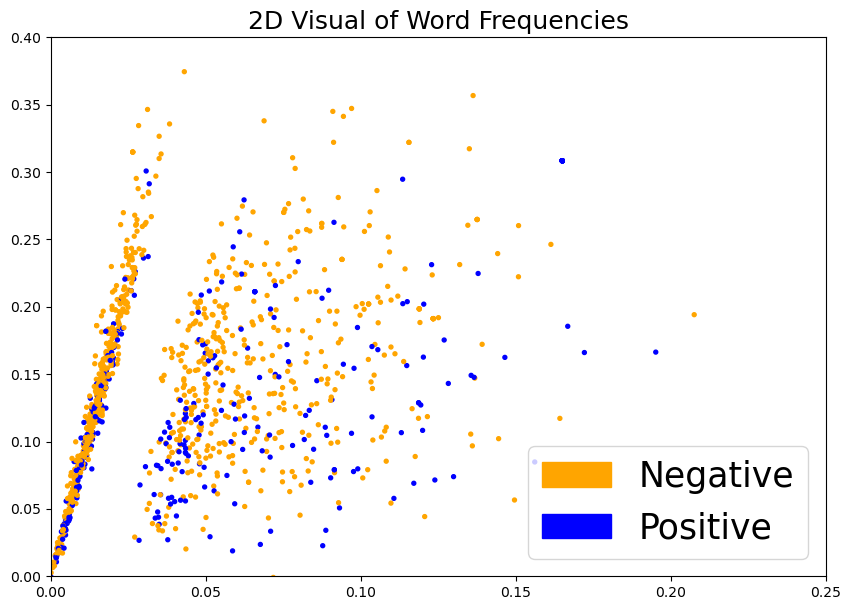

In [15]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['orange', 'blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Negative')
        green_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})

fig = plt.figure(figsize =(10,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.25)
plt.ylim(0,0.4)
plt.title("2D Visual of Word Frequencies", size = 18)
plt.show()

## 2. Model Building and Evaluation
### 2.1 Model Building
Here we will compare a simple logistic regression with a SVM that is tweaked with GridSearchCV.

In [16]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV()
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline



clf = SVC(class_weight = 'balanced')
pipe = Pipeline([('classifier', clf)])
fit_params = {'classifier__kernel':['rbf', 'linear', 'poly'],
          'classifier__degree':[2, 3, 4],
          'classifier__C':[0.01, 0.1, 1, 10]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train_tfidf, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'],
                classifier__kernel = gs.best_params_['classifier__kernel'],
               classifier__C = gs.best_params_['classifier__C'])
pipe.fit(X_train_tfidf, y_train)
y_pred = pipe.predict(X_test_tfidf)

Best performing classifier parameters (score 0.8416377515614158):
{'classifier__C': 10, 'classifier__degree': 2, 'classifier__kernel': 'linear'}


As we can see the best performing SVM had a linear kernel and default regularization strength. This might mean that in practice the best possible SVM and a simple Logistic Regression might be about the same.

## 2.2 Model Evaluation
Below we see that the Logistic Regression has a slight performance lead on the linear SVM. At 89% accuracy, we have built a model that is pretty good given the limited data we had.

Guessing the most comon class would give 74.2% accurace, so our classifier is doing well. Note a fairly even precision and recall for both classes.

In [18]:
from sklearn.metrics import accuracy_score, classification_report

#Logistic Regression Eval
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_logr))
print('\nLogistic Classification Report: \n' , classification_report(y_test,  y_pred_logr))

#SVM Eval
print('\n\n SVM Accuracy: ', accuracy_score(y_test, y_pred))
print('\nSVM Classification Report: \n' , classification_report(y_test,  y_pred))

Logistic Regression Accuracy:  0.7203647416413373

Logistic Classification Report: 
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       226
           1       0.60      0.33      0.42       103

    accuracy                           0.72       329
   macro avg       0.67      0.61      0.62       329
weighted avg       0.70      0.72      0.69       329



 SVM Accuracy:  0.7264437689969605

SVM Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.88      0.82       226
           1       0.60      0.38      0.46       103

    accuracy                           0.73       329
   macro avg       0.68      0.63      0.64       329
weighted avg       0.71      0.73      0.71       329



### 2.2.1 Confusion Matrix
Our model has a preference towards giving false negatives rather than false positives. We look at some examples of misclassified tweets below.

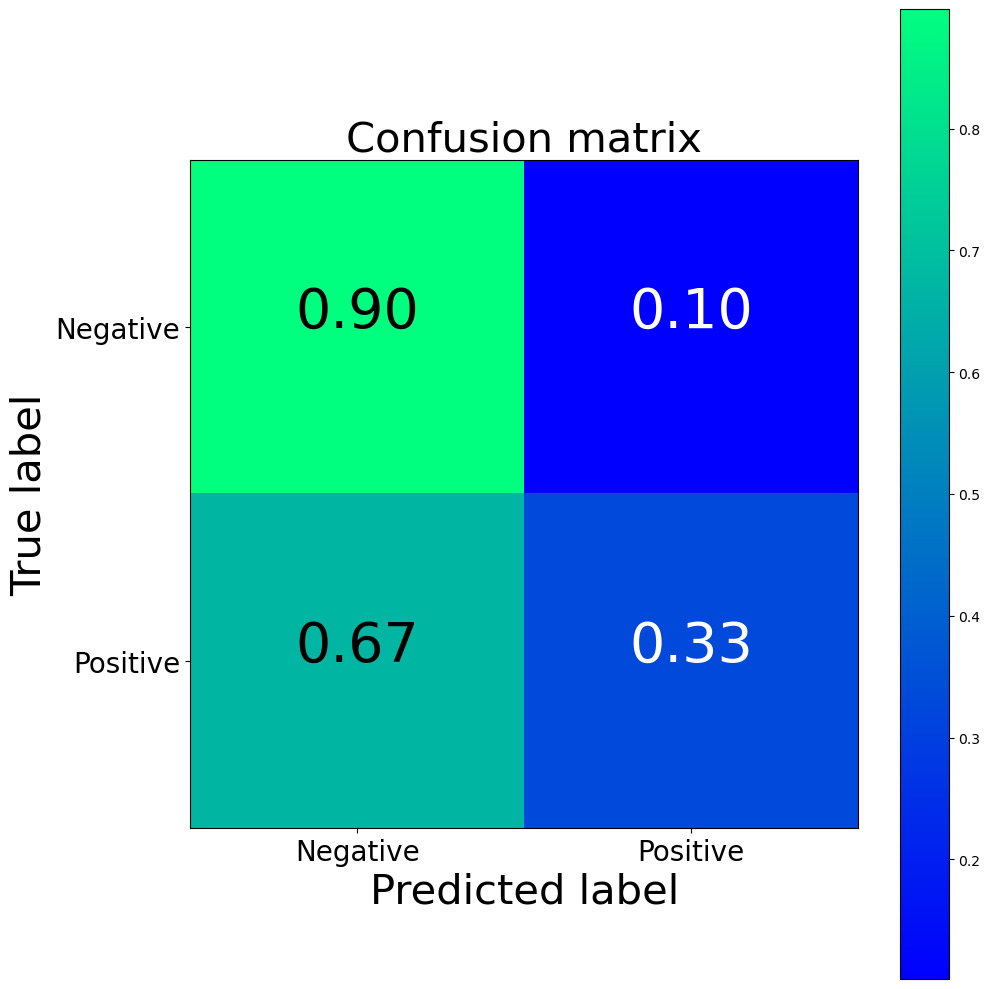

[[203  23]
 [ 69  34]]


In [19]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

### 2.2.2 Word Importances
As illustrated by the image below, our model clearly picks up on words that might predict s positive or negative tweet. Another interesting thing to note, "facetime" and "charger" are both words witha significant NEGATIVE connotation. Perhaps twitter users do not like these things?

In [20]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)

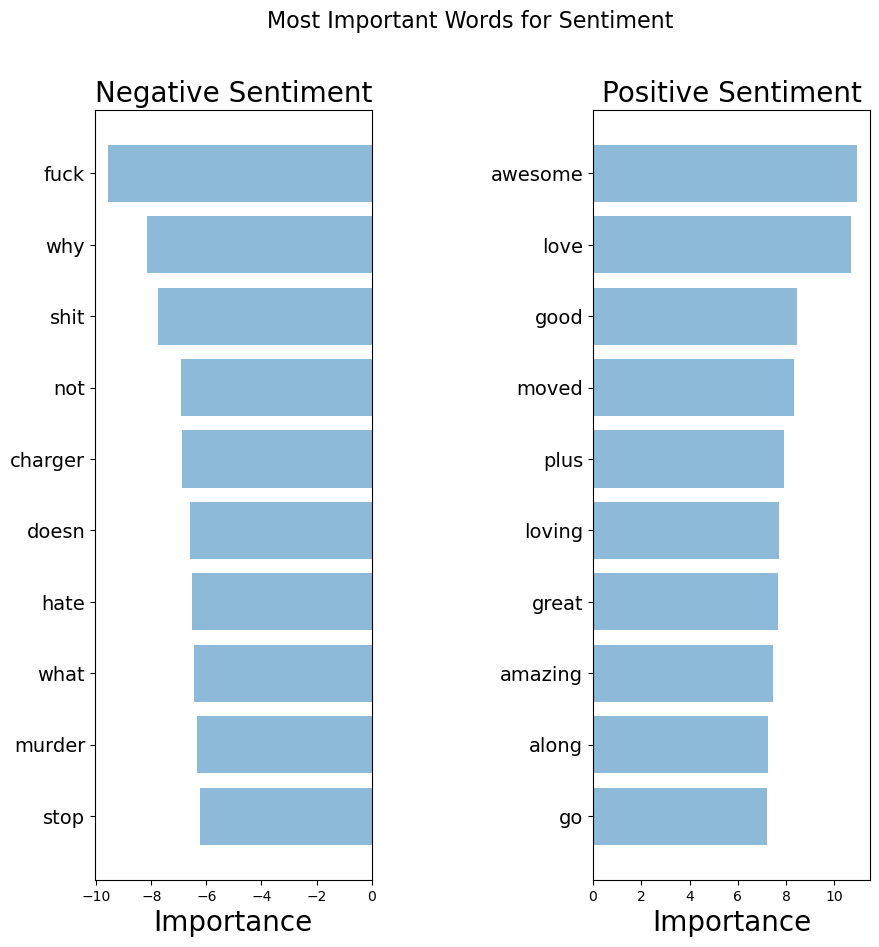

In [21]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")

### 3. Conclusion
We built a linear model that predicts the sentiment of tweets about Apple at around 89% accuracy. The Confusion Matrix showed a tendency towards false negatives. Lastly we showed that the model succesfully inferred the importance of some english words to twitter sentiment.